In [231]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir
print(tf.__version__)

2.0.0


In [146]:
os.listdir("/Users/tomjeong/Downloads/breast-histopathology-images")

['9036',
 '10268',
 '10257',
 '8913',
 '13613',
 '8914',
 '15510',
 '10259',
 '16165',
 '10292',
 '12951',
 '10261',
 '10295',
 '9259',
 '12750',
 '13020',
 '16552',
 '12905',
 '9266',
 '16555',
 '13018',
 '9261',
 '9257',
 '12934',
 '12933',
 '9250',
 '10260',
 '10258',
 '10293',
 '9037',
 '10269',
 '16531',
 '10256',
 '15516',
 '12932',
 '12935',
 '9256',
 '16554',
 '9260',
 '13019',
 '16553',
 '13021',
 '8984',
 '9258',
 '12751',
 '9267',
 '12876',
 '12882',
 '15634',
 '12871',
 '14188',
 '15633',
 '9324',
 '12878',
 '.DS_Store',
 '9323',
 '9383',
 '8867',
 '9346',
 '9174',
 '12822',
 '9173',
 '9322',
 '9325',
 '12879',
 '14189',
 '12870',
 '12884',
 '12241',
 '15632',
 '12883',
 '12877',
 '9126',
 '13106',
 '12823',
 '13591',
 '9175',
 '12824',
 '9347',
 '9181',
 '9382',
 '10307',
 '13916',
 '10300',
 '14306',
 '15471',
 '16896',
 '14156',
 '9135',
 '12890',
 '12897',
 '10308',
 '10301',
 '10306',
 '12896',
 '14157',
 '12891',
 '12898',
 '14192',
 '13458',
 '9083',
 '9077',
 '13460

In [147]:
base_path = "/Users/tomjeong/Downloads/breast-histopathology-images/IDC_regular_ps50_idx5/"

In [148]:
## finding the number of patients. 
folder = os.listdir(base_path)
len(folder)

280

In [149]:
total_images = 0
for n in range(0, len(folder)):
    patient_id = folder[n]
    print(patient_id)
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        
        class_path = patient_path + "/" + str(c) + "/"
        if not ".DS_Store" in class_path:
            subfiles = os.listdir(class_path)
            total_images += len(subfiles)

9036
10268
10257
8913
13613
8914
15510
10259
16165
10292
12951
10261
10295
9259
12750
13020
16552
12905
9266
16555
13018
9261
9257
12934
12933
9250
10260
10258
10293
9037
10269
16531
10256
15516
12932
12935
9256
16554
9260
13019
16553
13021
8984
9258
12751
9267
12876
12882
15634
12871
14188
15633
9324
12878
.DS_Store
9323
9383
8867
9346
9174
12822
9173
9322
9325
12879
14189
12870
12884
12241
15632
12883
12877
9126
13106
12823
13591
9175
12824
9347
9181
9382
10307
13916
10300
14306
15471
16896
14156
9135
12890
12897
10308
10301
10306
12896
14157
12891
12898
14192
13458
9083
9077
13460
8955
12910
9041
14210
14082
10274
9227
10273
13402
14078
9023
12911
14211
13691
9078
12929
13461
9076
13459
16570
9022
10288
9228
14079
10286
13403
10272
10275
13404
9226
13024
8975
16569
12901
9262
13023
16551
9265
12906
9291
12930
13688
12908
9254
16534
8917
15513
10253
9035
10254
15514
16533
13617
10262
12955
16166
10291
12909
9255
14209
12931
13689
16550
13022
12752
9290
12907
13687
8980
8974
13025
129

In [150]:
total_images

277524

In [151]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        if ".DS_Store" in class_path:
            pass
        else:
            subfiles = os.listdir(class_path)
            for m in range(len(subfiles)):
                image_path = subfiles[m]
                data.iloc[k]["path"] = class_path + image_path
                data.iloc[k]["target"] = c
                data.iloc[k]["patient_id"] = patient_id
                k += 1

In [152]:
data.shape

(277524, 3)

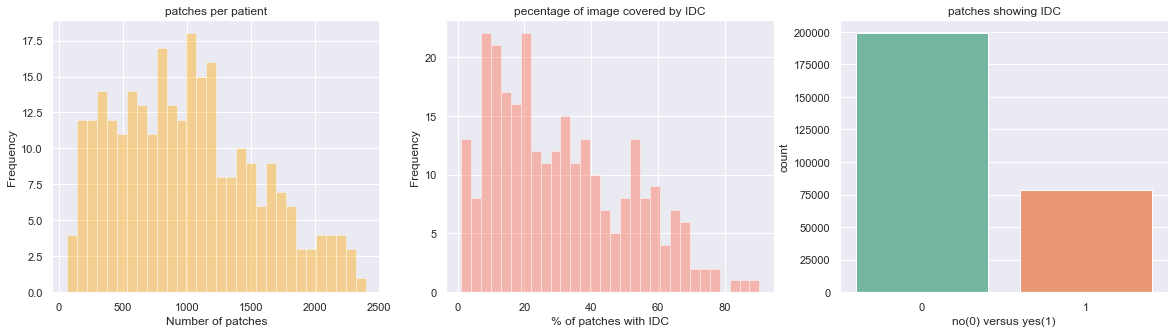

In [153]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack();

fig, ax = plt.subplots(1,3,figsize=(20,5));
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30);
ax[0].set_xlabel("Number of patches");
ax[0].set_ylabel("Frequency");
ax[0].set_title("patches per patient");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30);
ax[1].set_title("pecentage of image covered by IDC");
ax[1].set_ylabel("Frequency");
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)");
ax[2].set_title("patches showing IDC");


In [154]:
def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [155]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

,x,y,target,path
0,1051,2401,0,/Users/tomjeong/Downloads/breast-histopatholog...
1,2951,951,0,/Users/tomjeong/Downloads/breast-histopatholog...
2,3001,1451,0,/Users/tomjeong/Downloads/breast-histopatholog...
3,3051,801,0,/Users/tomjeong/Downloads/breast-histopatholog...
4,951,1901,0,/Users/tomjeong/Downloads/breast-histopatholog...


In [156]:
example.describe()

,x,y,target
count,1306.000000,1306.000000,1306.000000
mean,1950.119449,1433.733538,0.022971
std,735.243847,731.731867,0.149868
min,1.000000,51.000000,0.000000
25%,1501.000000,851.000000,0.000000
50%,1901.000000,1301.000000,0.000000
75%,2401.000000,2001.000000,0.000000
max,3551.000000,2851.000000,1.000000


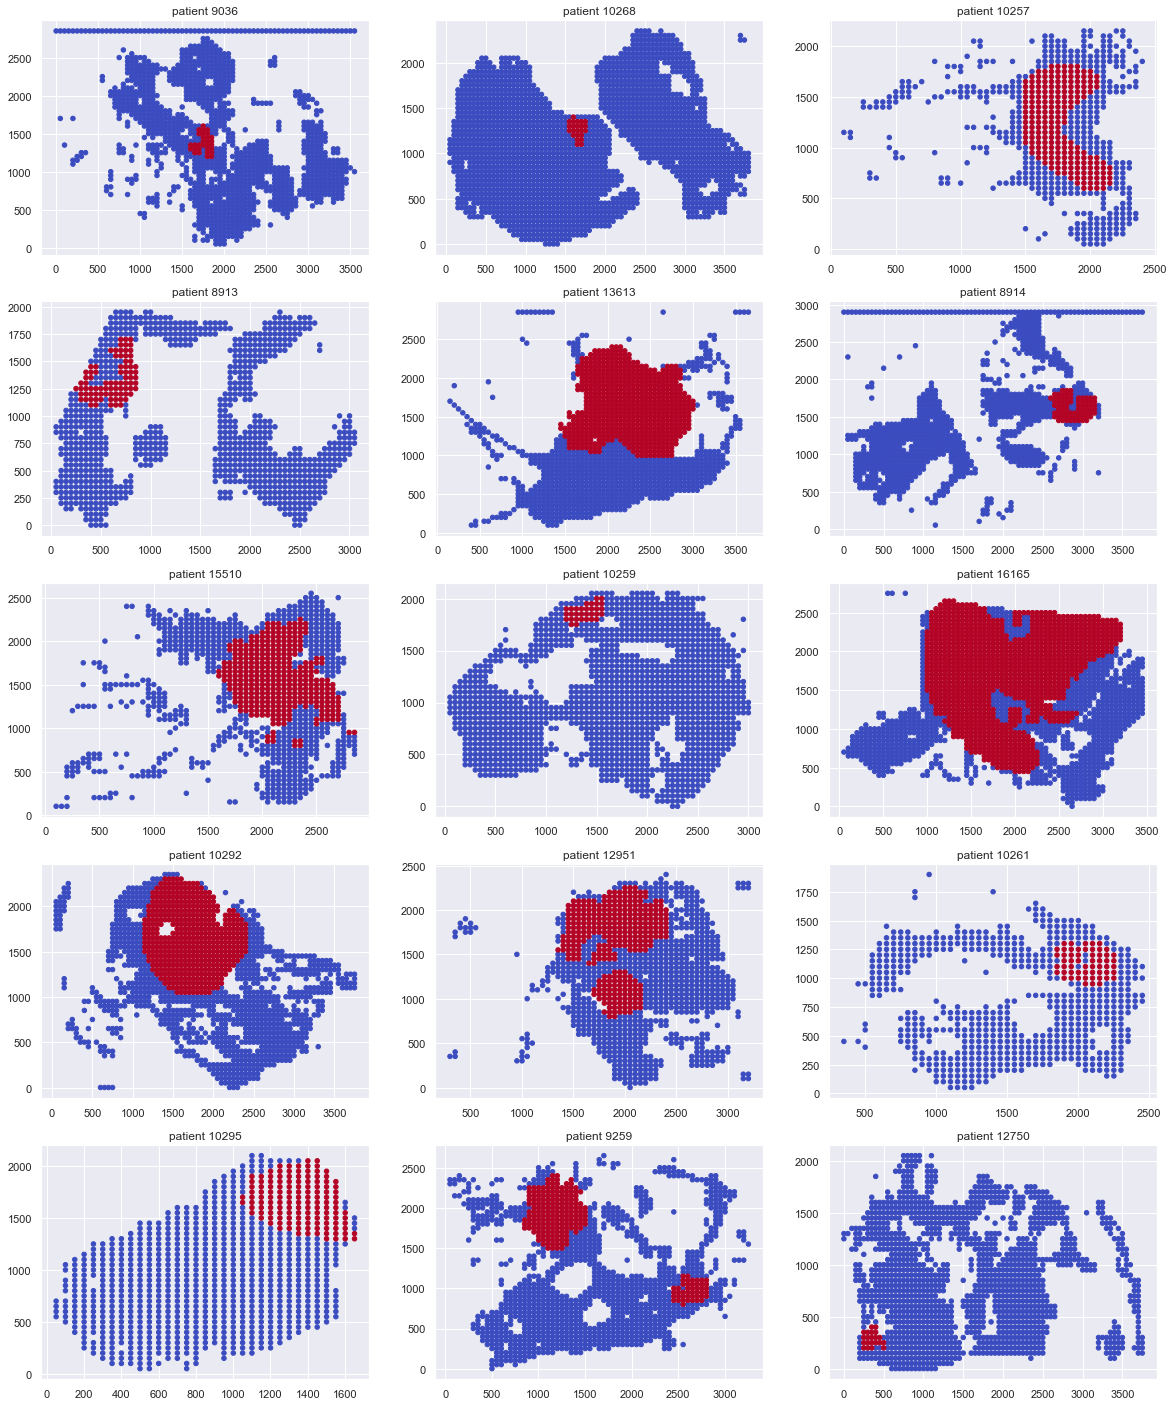

In [157]:
fig, ax = plt.subplots(5,3,figsize=(20, 25))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example = get_patient_dataframe(patient_id)
        ax[n,m].scatter(example.x.values, example.y.values, c=example.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)

In [158]:
def visualise_breast_tissue(patient_id):
    pass

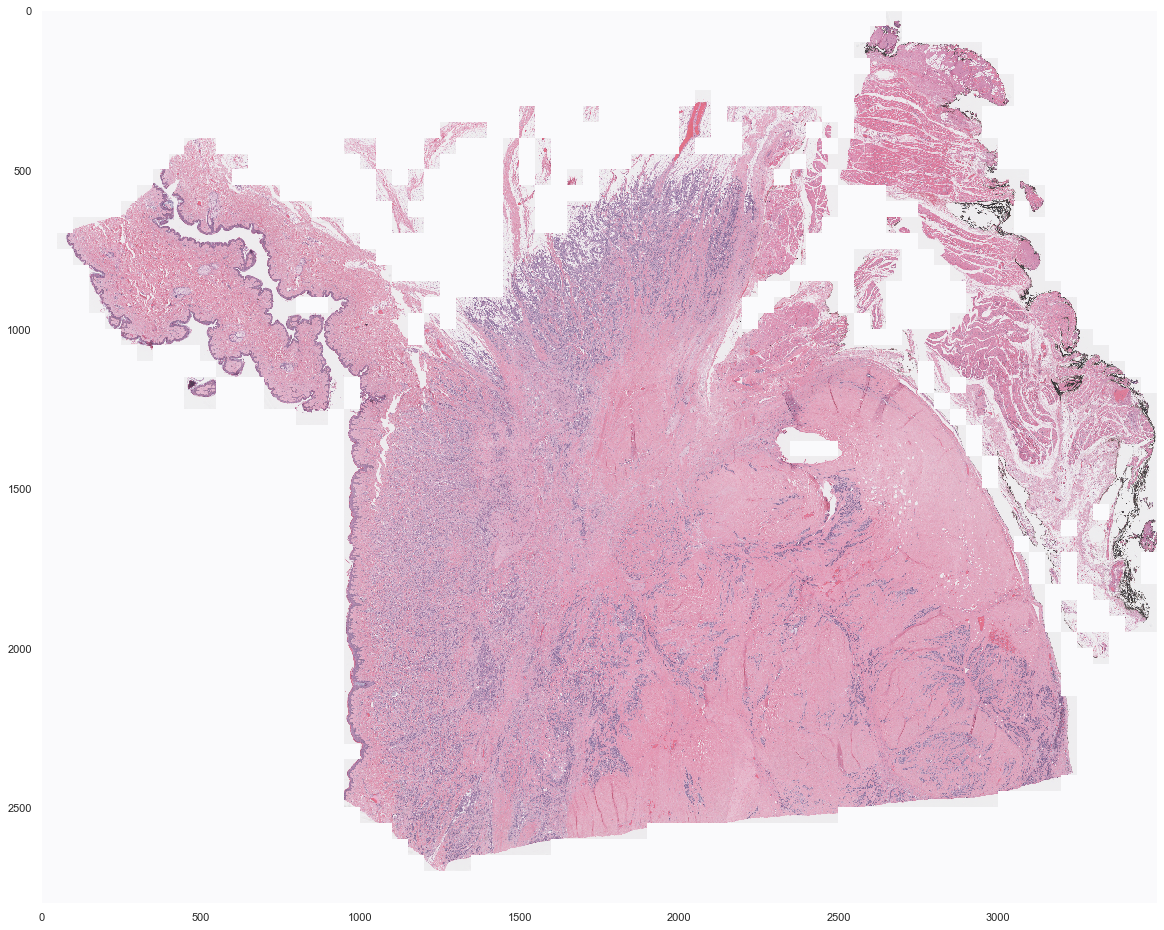

In [159]:
example = "16165"

example_df = get_patient_dataframe(example)
max_point = [example_df.y.max()-1, example_df.x.max()-1]
grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)

broken_patches = []
for n in range(len(example_df)):
    try:
        image = imread(example_df.path.values[n])

        x_start = example_df.x.values[n] - 1
        y_start = example_df.y.values[n] - 1
        x_end = x_start + 50
        y_end = y_start + 50

        grid[y_start:y_end, x_start:x_end] = image
     
#mask[y_start:y_end, x_start:x_end] = np.ones(shape=(50,50,3))
    except ValueError:
        broken_patches.append(example_df.path.values[n])

plt.figure(figsize=(20,20))
plt.imshow(grid, cmap="Blues", vmin=150, alpha=0.8)
plt.grid(False)

In [160]:
broken_patches

['/Users/tomjeong/Downloads/breast-histopathology-images/IDC_regular_ps50_idx5/16165/0/16165_idx5_x601_y2751_class0.png',
 '/Users/tomjeong/Downloads/breast-histopathology-images/IDC_regular_ps50_idx5/16165/0/16165_idx5_x551_y2751_class0.png',
 '/Users/tomjeong/Downloads/breast-histopathology-images/IDC_regular_ps50_idx5/16165/0/16165_idx5_x751_y2751_class0.png']

In [161]:
data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
patient_id    277524 non-null object
path          277524 non-null object
target        277524 non-null object
dtypes: object(3)
memory usage: 18.5+ MB


In [162]:
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.4,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [163]:
print(len(train_ids), len(dev_ids), len(test_ids))

167 56 56


In [164]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

In [165]:
class_weights = compute_class_weight(class_weight="balanced",
                                     y=train_df.target.astype(np.int),
                                     classes=[0,1])
class_weights

array([0.68937932, 1.82010191])

In [166]:
train_datagen = ImageDataGenerator(rescale=(1./255-0.5),
                                   horizontal_flip=True,
                                   vertical_flip=True)
dev_datagen = ImageDataGenerator(rescale=1./255-0.5)
test_datagen = ImageDataGenerator(rescale=(1./255-0.5))

In [167]:
BATCH_SIZE = 64

In [168]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="target",
        target_size=(50, 50),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
)

dev_generator = dev_datagen.flow_from_dataframe(
    dataframe=dev_df,
    x_col="path",
    y_col="target",
    target_size=(50, 50),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        target_size=(50, 50),
        batch_size=1,
        class_mode=None,
        shuffle=False
)

Found 170023 validated image filenames belonging to 2 classes.
Found 52364 validated image filenames belonging to 2 classes.
Found 55137 validated image filenames.


In [169]:
LR = 0.001
EPOCHS = 15

In [170]:
from tensorflow.python.keras import backend as k

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

In [171]:
dev_generator.__len__()

819

In [172]:
train_generator.__len__()

2657

In [173]:
class TrackHistory(Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get("val_loss"))

In [174]:
reduce_lr = ReduceLROnPlateau(patience=1, factor=0.5, verbose=1)
tracker = TrackHistory()

In [177]:
from tensorflow.python.keras import backend as k
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [223]:

def build_model():
    model = tf.keras.models.Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3),
                     strides=1,
                     padding="valid",
                     activation='relu',
                     input_shape=(50, 50, 3),
                     kernel_regularizer=l2(0.5),
                     kernel_initializer=he_normal()
                    ))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     strides=1,
                     padding="valid",
                     activation='relu',
                     kernel_regularizer=l2(0.5),
                     kernel_initializer=he_normal()
                    ))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_regularizer=l2(0.5),
                     kernel_initializer=he_normal()))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     kernel_regularizer=l2(0.5),
                     kernel_initializer=he_normal(),
                     activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(filters=128,
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_regularizer=l2(0.5),
                     kernel_initializer=he_normal()))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(filters=128,
                     kernel_size=(3, 3),
                     kernel_regularizer=l2(0.5),
                     kernel_initializer=he_normal(),
                     activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(64,
                    kernel_regularizer=l2(0.1),
                    kernel_initializer=he_normal(),
                    activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

model = build_model()
model.compile(optimizer=Adam(lr=LR),
              loss='binary_crossentropy',
              metrics=['accuracy', precision, recall, fbeta_score]) 

history = model.fit_generator(train_generator,
                              steps_per_epoch=1000,#train_generator.__len__(),
                              epochs=EPOCHS,
                              verbose=1,
                              validation_data=dev_generator,
                              validation_steps=dev_generator.__len__(),
                              callbacks=[reduce_lr, tracker],
                              class_weight={0.: class_weights[0], 1.: class_weights[1]},
                              use_multiprocessing=True, 
                              workers=8
                             )

SyntaxError: keyword argument repeated (<ipython-input-223-3f8ab5b885fd>, line 78)

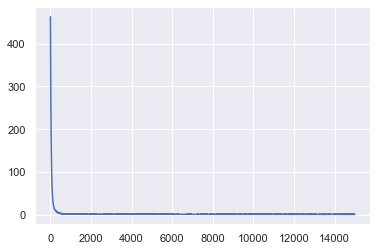

In [224]:
plt.figure()
plt.plot(tracker.losses)

In [200]:

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


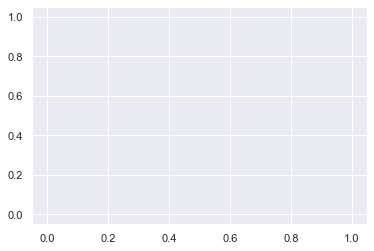

In [187]:
plt.figure()
plt.plot(tracker.val_losses)

In [183]:
print(history.history.keys())


dict_keys(['loss', 'acc', 'precision', 'recall', 'fbeta_score', 'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_fbeta_score', 'lr'])


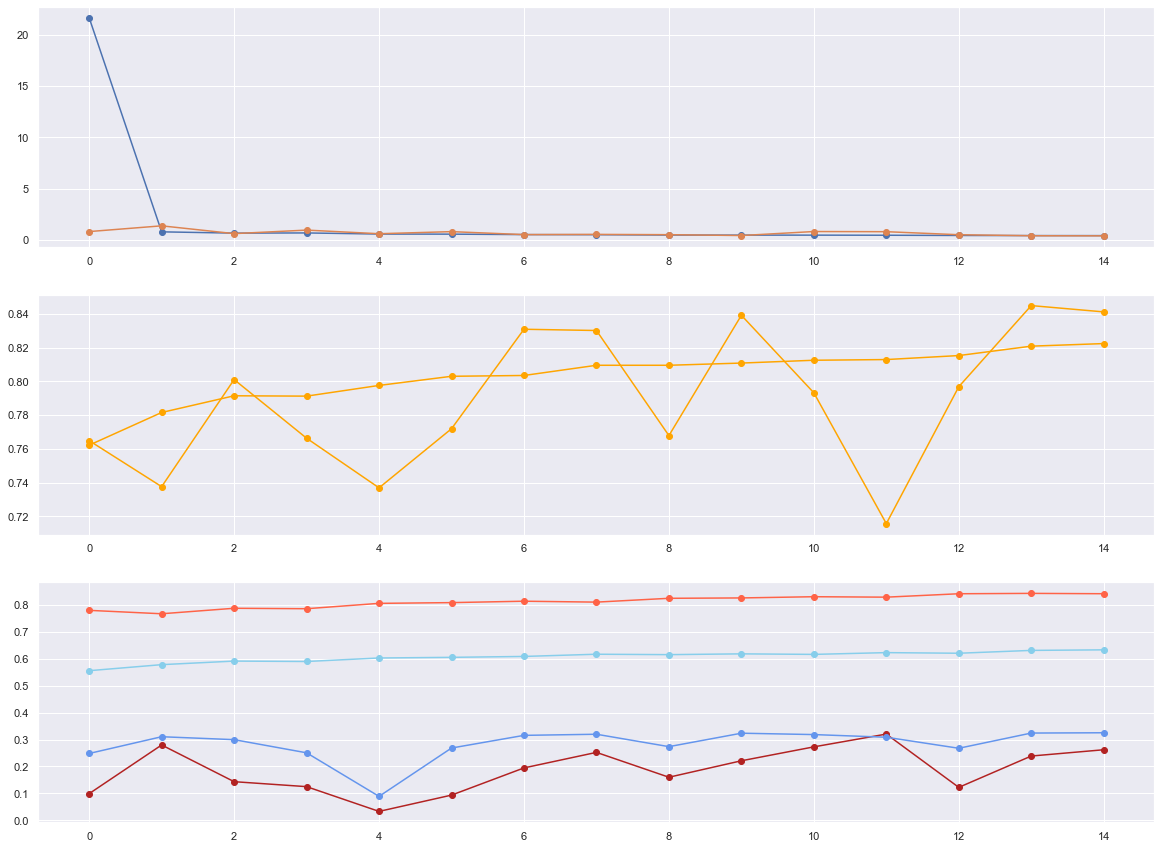

In [184]:
fig, ax = plt.subplots(3,1,figsize=(20,15))
ax[0].plot(history.history["loss"], 'o-')
ax[0].plot(history.history["val_loss"], 'o-')
ax[1].plot(history.history["acc"], 'o-', c="orange");
ax[1].plot(history.history["val_acc"], 'o-', c="orange");
ax[2].plot(history.history["recall"], 'o-', c="tomato")
ax[2].plot(history.history["val_recall"], 'o-', c="firebrick")
ax[2].plot(history.history["precision"], 'o-', c="skyblue")
ax[2].plot(history.history["val_precision"], 'o-', c="cornflowerblue")